In [10]:
#general data
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Embedding, Input, concatenate
import scipy
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Model
from keras.layers import BatchNormalization
from keras.metrics import AUC

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import Flatten

from scipy.io import loadmat
import numpy as np

from sklearn.preprocessing import StandardScaler

X_all = []
y_all = []

ch_ch = list(range(63))
g_ch = list(range(61))
ch_rem = [0, 2, 6, 8, 29, 31, 51, 55]
g_rem = [46, 49, 56, 58, 59, 60]

for i in ch_rem:
    ch_ch.remove(i)

for j in g_rem:
    g_ch.remove(j)

print("Chinese load")
for subj in range(1, 10):
    file_path = "C:\\Users\\USER\\Desktop\\RA\\data_ch\\ASK\\sbj_{}.mat".format(subj)

    try:
        print(f"Loading file: {file_path}")
        mat_data = loadmat(file_path)

        '''
        print(f"Keys in {file_path}: {mat_data.keys()}")
        # Loop through all features and print first 5 rows
        for key in mat_data.keys():
            if key not in ["__header__", "__version__", "__globals__"]:
                feature_data = np.array(mat_data[key])
                print(f"\nFeature: {key}, Shape: {feature_data.shape}")
                print("First 5 rows:\n", feature_data[:5])  # Print first 5 rows
        '''

        # Extract data
        X = np.array(mat_data['x_post'])[:-1, ch_ch, :]
        y = np.array(mat_data['label_next_ind'])[0, :]

        print("X's shape from the Chinese data", X.shape)

        # Transpose X (if necessary)
        X = np.transpose(X)
        print("X's shape from the Chinese data AFTER TRANSPOSING", X.shape)

        # Append data
        X_all.append(X)
        y_all.append(y)

    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

print("Korean load")
for subj in range(1, 15):
    file_path = 'C:\\Users\\USER\\Desktop\\RA\\data\\ASK\\sbj_{}.mat'.format(subj)
    try:
        with h5py.File(file_path, 'r') as f:
            print(f"Loading file: {file_path}")
            print(f"Keys in {file_path}: {list(f.keys())}")
            X = np.array(f['x_post'])[:, g_ch, :]
            y = np.array(f['label_next_ind'])[:, 0]
        X_all.append(X)
        y_all.append(y)
    except OSError as e:
        print(f"Error loading file {file_path}: {e}")


data = np.concatenate(X_all, axis=0)
labels = np.concatenate(y_all, axis=0)


print("Shape of data before flattening:", data.shape)
#print("Length of the first row before flattening:", data[0].shape)
#print("Rows of data:\n", data[:])  # Print samples

data_flattened = data.reshape(data.shape[0], -1)

#print("First row of flattened data:\n", data_flattened[0])
#print("Shape of data_flattened:", data_flattened.shape)  # (samples, features)
#print("Length of the first row after flattening:", data_flattened[0].shape)
#print("Rows of data_flattened:\n", data_flattened[:])  # Print samples

scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_flattened)
data_normalized = data_normalized.reshape(data.shape)

#print("First row of normalized data:\n", data_normalized[0])
print("Shape of normalized data:", data_normalized.shape)


Chinese load
Loading file: C:\Users\USER\Desktop\RA\data_ch\ASK\sbj_1.mat
X's shape from the Chinese data (100, 55, 996)
X's shape from the Chinese data AFTER TRANSPOSING (996, 55, 100)
Loading file: C:\Users\USER\Desktop\RA\data_ch\ASK\sbj_2.mat
X's shape from the Chinese data (100, 55, 884)
X's shape from the Chinese data AFTER TRANSPOSING (884, 55, 100)
Loading file: C:\Users\USER\Desktop\RA\data_ch\ASK\sbj_3.mat
X's shape from the Chinese data (100, 55, 996)
X's shape from the Chinese data AFTER TRANSPOSING (996, 55, 100)
Loading file: C:\Users\USER\Desktop\RA\data_ch\ASK\sbj_2.mat
X's shape from the Chinese data (100, 55, 884)
X's shape from the Chinese data AFTER TRANSPOSING (884, 55, 100)
Loading file: C:\Users\USER\Desktop\RA\data_ch\ASK\sbj_3.mat
X's shape from the Chinese data (100, 55, 1291)
X's shape from the Chinese data AFTER TRANSPOSING (1291, 55, 100)
Loading file: C:\Users\USER\Desktop\RA\data_ch\ASK\sbj_4.mat
X's shape from the Chinese data (100, 55, 908)
X's shape fr

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, DepthwiseConv2D, SeparableConv2D, GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam

def EEGNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(8, (1, 32), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.25)(x)

    x = DepthwiseConv2D((55, 1), depth_multiplier=2, use_bias=False, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.25)(x)

    x = SeparableConv2D(16, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.25)(x)

    x = GlobalAveragePooling2D()(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (55, 100, 1)
num_classes = 2

model = EEGNet(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 55, 100, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 100, 8)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 55, 100, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 55, 100, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 55, 100, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 1, 100, 16)     │           880 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 100, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 1, 100, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 100, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 1, 100, 16)     │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 100, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 1, 100, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 100, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,842 (7.20 KB)

 Trainable params: 1,762 (6.88 KB)

 Non-trainable params: 80 (320.00 B)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X = data_normalized[..., np.newaxis]
y = labels
smt = SMOTE(random_state=42)
X = X.astype(np.float32)
y = y.astype(np.int32)

X_train_s, X_temp, y_train_s, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = smt.fit_resample(X_train_s.reshape(X_train_s.shape[0], -1), y_train_s)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape X_train back to original shape for the model
X_train = X_train.reshape(X_train.shape[0], 55, 100, 1)

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (51418, 55, 100, 1)
y_train shape: (51418,)
X_val shape: (5044, 55, 100, 1)
y_val shape: (5044,)
X_test shape: (5044, 55, 100, 1)
y_test shape: (5044,)


In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.5311 - loss: 0.6891 - val_accuracy: 0.6346 - val_loss: 0.6808
Epoch 2/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.5311 - loss: 0.6891 - val_accuracy: 0.6346 - val_loss: 0.6808
Epoch 2/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5544 - loss: 0.6847 - val_accuracy: 0.4655 - val_loss: 0.6961
Epoch 3/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5544 - loss: 0.6847 - val_accuracy: 0.4655 - val_loss: 0.6961
Epoch 3/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5687 - loss: 0.6798 - val_accuracy: 0.4673 - val_loss: 0.6908
Epoch 4/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5687 - loss: 0.6798 - val_accuracy: 0.4673 - val_loss: 0.6908
Epoch 4/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5817 - loss: 0.6759 - val_accuracy: 0.4617 - val_loss: 0.7063
Epoch 5/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.5916 - loss:

In [14]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5295 - loss: 0.6843
Test Accuracy: 52.95%
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5295 - loss: 0.6843
Test Accuracy: 52.95%


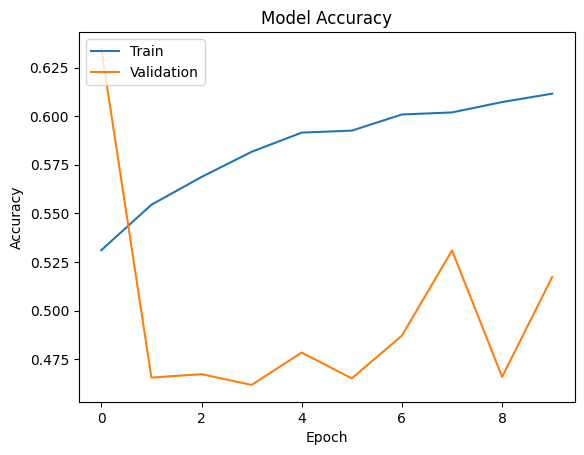

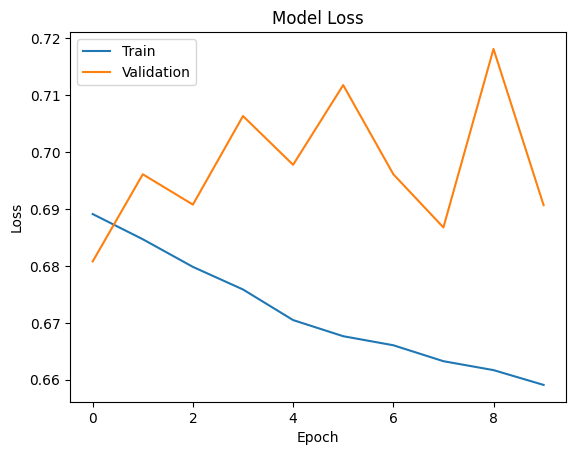

In [15]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


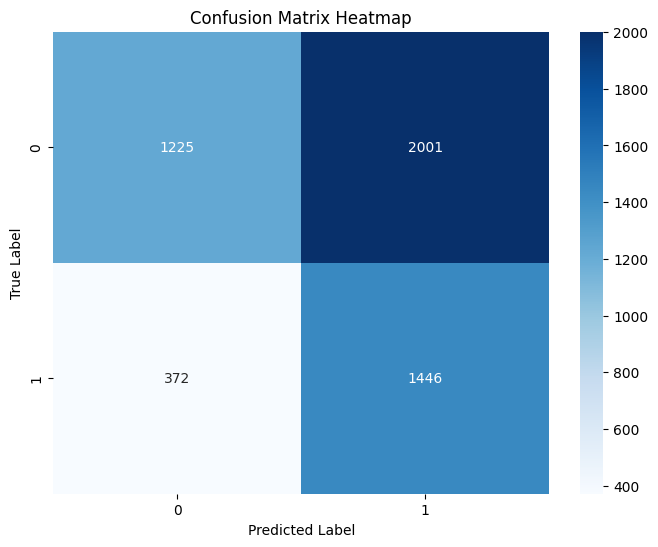

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.38      0.51      3226
           1       0.42      0.80      0.55      1818

    accuracy                           0.53      5044
   macro avg       0.59      0.59      0.53      5044
weighted avg       0.64      0.53      0.52      5044



In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict class labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))